Data set was obtained from Kaggle: https://www.kaggle.com/datasets/abdullahkhanuet22/eggs-images-classification-damaged-or-not/*code*

Part of this code was adapted from: https://www.kaggle.com/code/sakibulislam216/training-eggs

In [ ]:
pip install Pillow matplotlib opencv-python



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from keras.callbacks import CSVLogger
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tqdm import tqdm
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
import torch
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error
from mlxtend.evaluate import bias_variance_decomp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

In [ ]:
import tensorflow as tf
import pandas as pd
import pickle
import os
import cv2
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import convert_to_tensor
from pathlib import Path
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob


In [ ]:
# TRain test split
import cv2
import os
import numpy as np
import random
from tensorflow.keras.utils import to_categorical

def load_images_from_folder(folder, label):
    images = []
    labels = []
    image_files = os.listdir(folder)
    image_labels = [(os.path.join(folder, image_file), label) for image_file in image_files]
    random.shuffle(image_labels)  # Shuffle images within each class

    for img_path, label in image_labels:
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (200, 200))  # Resize images to 200x200
            images.append(img)
            labels.append(label)
    return images, labels

def load_data(training_dir, testing_dir):
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    # Load training data
    train_labels = sorted(os.listdir(training_dir))
    train_data = []
    for i, label in enumerate(train_labels):
        folder_path = os.path.join(training_dir, label)
        imgs, lbls = load_images_from_folder(folder_path, i)
        train_data.extend(zip(imgs, lbls))

    random.shuffle(train_data)  # Shuffle all training data
    X_train, y_train = zip(*train_data)
    X_train = list(X_train)
    y_train = list(y_train)

    # Load testing data
    test_labels = sorted(os.listdir(testing_dir))
    test_data = []
    for i, label in enumerate(test_labels):
        folder_path = os.path.join(testing_dir, label)
        imgs, lbls = load_images_from_folder(folder_path, i)
        test_data.extend(zip(imgs, lbls))

    random.shuffle(test_data)  # Shuffle all testing data
    X_test, y_test = zip(*test_data)
    X_test = list(X_test)
    y_test = list(y_test)

    # Convert lists to numpy arrays and one-hot encode labels
    X_train = np.array(X_train)
    y_train = to_categorical(y_train, num_classes=2)
    X_test = np.array(X_test)
    y_test = to_categorical(y_test, num_classes=2)

    return X_train, y_train, X_test, y_test

# Paths to the training and testing directories
training_dir = '/home/station2/Downloads/Egg/training'
testing_dir = '/home/station2/Downloads/Egg/testing'

# Load the dataset
X_train, y_train, X_test, y_test = load_data(training_dir, testing_dir)

# Check shapes of the datasets
print("Shapes of the datasets:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)  # Should be (n, 2)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)  # Should be (n, 2)


Shapes of the datasets:
X_train: (634, 200, 200, 3)
y_train: (634, 2)
X_test: (160, 200, 200, 3)
y_test: (160, 2)


In [ ]:
from tensorflow.keras.models import Sequential
def create_model():
    model = Sequential([
        Conv2D(filters=16, kernel_size=(3, 3), padding='valid',input_shape=(X_train[0].shape)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=128, kernel_size=(3, 3), padding= 'valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),

        Dense(units=512, activation='relu'),
        Dropout(0.2),
        Dense(units=2, activation='softmax')
    ])

    return model

model = create_model()
model.summary()

In [ ]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(), metrics=['accuracy'])


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
20/20 [==============================] - 2s 46ms/step - loss: 0.4662 - accuracy: 0.7823 - val_loss: 0.5463 - val_accuracy: 0.7437
Epoch 2/100
20/20 [==============================] - 1s 41ms/step - loss: 0.2277 - accuracy: 0.9006 - val_loss: 0.5385 - val_accuracy: 0.7312
Epoch 3/100
20/20 [==============================] - 1s 41ms/step - loss: 0.1724 - accuracy: 0.9338 - val_loss: 0.5620 - val_accuracy: 0.7625
Epoch 4/100
20/20 [==============================] - 1s 41ms/step - loss: 0.1198 - accuracy: 0.9732 - val_loss: 0.5039 - val_accuracy: 0.8062
Epoch 5/100
20/20 [==============================] - 1s 41ms/step - loss: 0.0866 - accuracy: 0.9795 - val_loss: 0.3862 - val_accuracy: 0.8500
Epoch 6/100
20/20 [==============================] - 1s 41ms/step - loss: 0.0753 - accuracy: 0.9842 - val_loss: 0.3688 - val_accuracy: 0.8562
Epoch 7/100
20/20 [==============================] - 1s 41ms/step - loss: 0.0668 - accuracy: 0.9826 - val_loss: 0.2975 - val_accuracy: 0.8875
Epoch 

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

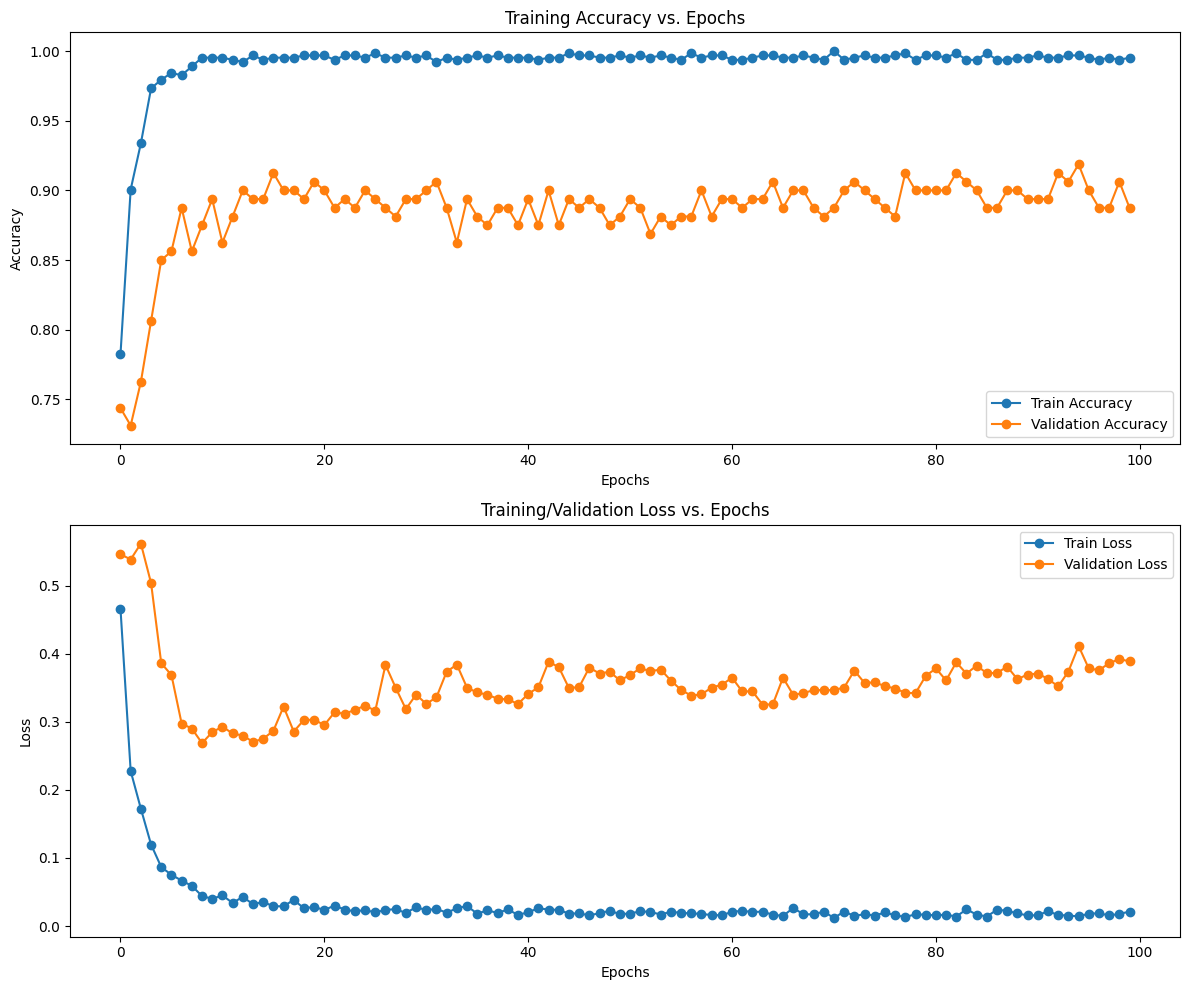

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

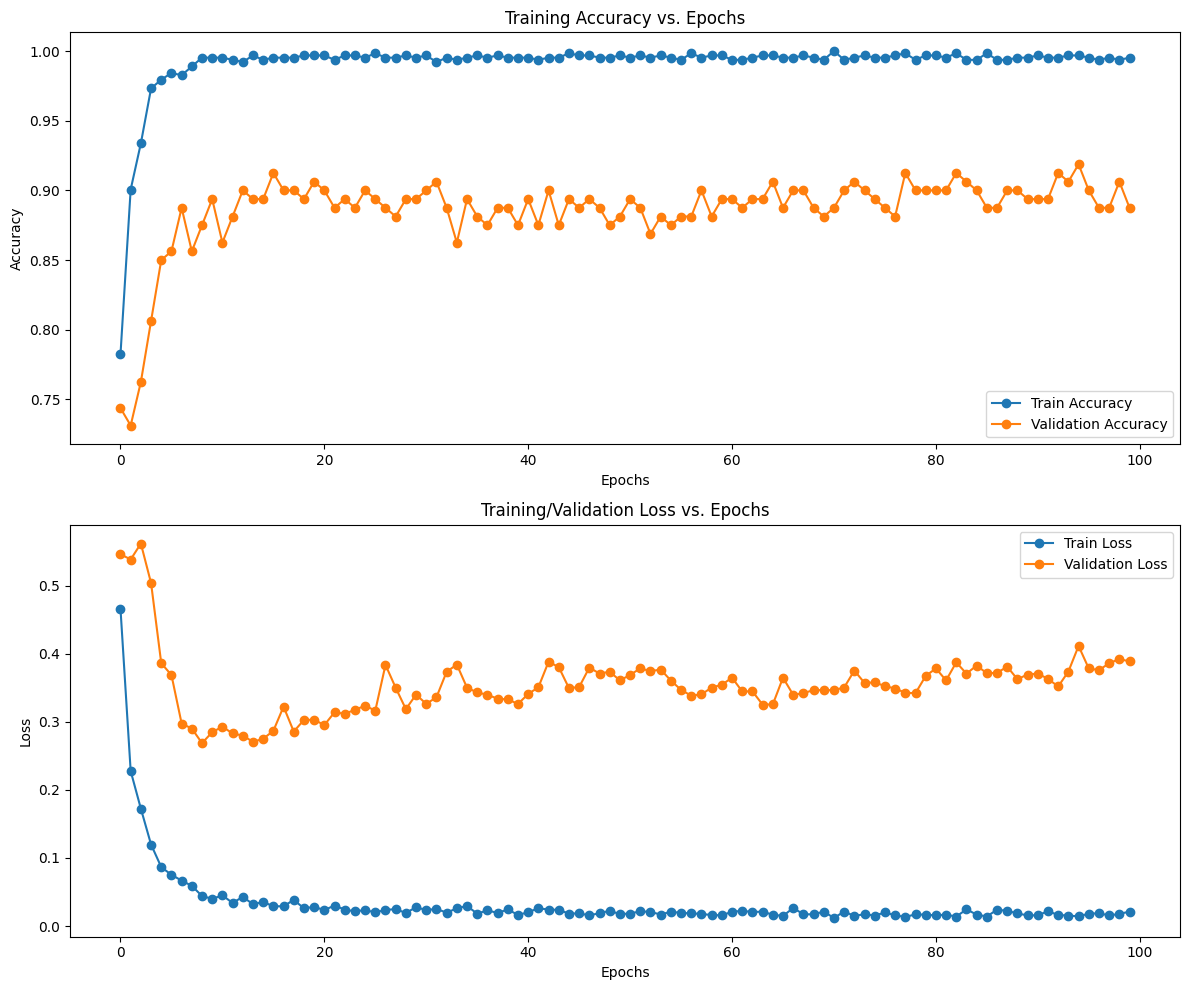

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import average_precision_score
import numpy as np
predictions = model.predict(X_test)

threshold = 0.5
binary_predictions = np.where(predictions > threshold, 1, 0)

# Assuming y_test is already in a binary format (each element is either 0 or 1)
num_classes = predictions.shape[1]
average_precisions = []
for i in range(num_classes):
    # Calculate average precision for each class
    ap = average_precision_score(y_test[:, i], predictions[:, i])
    average_precisions.append(ap)
map_score = np.mean(average_precisions)
print(f"Mean Average Precision (MAP): {map_score}")

5/5 [==============================] - 0s 13ms/step
Mean Average Precision (MAP): 0.8902876832739914


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Calculate precision, recall, and F1-score with a suitable average method for multilabel classification
average_method = 'macro'  # Choose 'micro', 'macro', 'weighted', or 'samples' based on your specific needs

precision = precision_score(y_test, binary_predictions, average=average_method)
recall = recall_score(y_test, binary_predictions, average=average_method)
f1 = f1_score(y_test, binary_predictions, average=average_method)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# Calculate AUROC per class and take the average if AUROC calculation is meaningful
# Note: AUROC can be misleading in multilabel settings if not handled carefully
try:
    auroc = roc_auc_score(y_test, predictions, average=average_method, multi_class='ovr')
    print(f"AUROC: {auroc}")
except ValueError as e:
    print("AUROC calculation error:", e)

# Confusion matrix is not directly meaningful in multilabel settings, you can compute it for each class separately if needed
for i in range(y_test.shape[1]):  # Assuming y_test and binary_predictions are 2D arrays
    cm = confusion_matrix(y_test[:, i], binary_predictions[:, i])
    print(f"Confusion Matrix for class {i}:\n{cm}")


Precision: 0.8282032927702219
Recall: 0.8282032927702219
F1-Score: 0.8282032927702219
AUROC: 0.9408255786208544
Confusion Matrix for class 0:
[[ 24   9]
 [  9 118]]
Confusion Matrix for class 1:
[[118   9]
 [  9  24]]


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
# Convert softmax probabilities to predicted class (0 or 1)
predicted_classes = np.argmax(predictions, axis=1)
# Convert y_test from one-hot to single class
true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", cm)

# Precision, Recall, F1-Score
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# AUROC (Note: AUROC for multi-class requires probability scores)
# Ensure 'average' parameter is correctly set for multi-class (one-vs-rest approach)
auroc = roc_auc_score(y_test, predictions, multi_class='ovr')
print(f"AUROC: {auroc}")


Confusion Matrix:
 [[118   9]
 [  9  24]]
Precision: 0.7272727272727273
Recall: 0.7272727272727273
F1-Score: 0.7272727272727273
AUROC: 0.9408255786208544


VGG

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json


In [ ]:
#Allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d abdullahkhanuet22/eggs-images-classification-damaged-or-not


 96% 96.0M/100M [00:02<00:00, 45.1MB/s]
100% 100M/100M [00:02<00:00, 40.5MB/s] 


In [ ]:
! unzip eggs-images-classification-damaged-or-not.zip

Archive:  eggs-images-classification-damaged-or-not.zip
  inflating: Eggs Classification/Damaged/damaged_1.jpg  
  inflating: Eggs Classification/Damaged/damaged_10.jpg  
  inflating: Eggs Classification/Damaged/damaged_100.jpg  
  inflating: Eggs Classification/Damaged/damaged_101.jpg  
  inflating: Eggs Classification/Damaged/damaged_102.jpg  
  inflating: Eggs Classification/Damaged/damaged_103.jpg  
  inflating: Eggs Classification/Damaged/damaged_104.jpg  
  inflating: Eggs Classification/Damaged/damaged_105.jpg  
  inflating: Eggs Classification/Damaged/damaged_106.jpg  
  inflating: Eggs Classification/Damaged/damaged_107.jpg  
  inflating: Eggs Classification/Damaged/damaged_108.jpg  
  inflating: Eggs Classification/Damaged/damaged_109.jpg  
  inflating: Eggs Classification/Damaged/damaged_11.jpg  
  inflating: Eggs Classification/Damaged/damaged_110.jpg  
  inflating: Eggs Classification/Damaged/damaged_111.jpg  
  inflating: Eggs Classification/Damaged/damaged_112.jpg  
  in

In [ ]:
import os
dir_path ='/content/Eggs Classification'
# Check if the directory exists
if os.path.exists(dir_path):
    # List all files and directories in the specified directory
    print("Files and directories in '", dir_path, "' :")
    print(os.listdir(dir_path))
else:
    print("The directory does not exist.")

Files and directories in ' /content/Eggs Classification ' :
['Damaged', 'Not Damaged']


In [ ]:

from PIL import Image
import os
import glob
train_path = '/content/Eggs Classification'
valid_path = '/content/Eggs Classification/Not Damaged'


# Path to the 'Damaged' folder
damaged_path = '/content/Eggs Classification/Damaged'

# List all files in the 'Damaged' folder
print(os.listdir(damaged_path))

# Path to the 'Damaged' folder
Not_damaged_path = '/content/Eggs Classification/Not Damaged'

# List all files in the 'Damaged' folder
print(os.listdir(Not_damaged_path))

['damaged_273.jpg', 'damaged_351.jpg', 'damaged_214.jpg', 'damaged_370.jpg', 'damaged_417.jpg', 'damaged_335.jpg', 'damaged_438.jpg', 'damaged_598.jpg', 'damaged_590.jpg', 'damaged_450.jpg', 'damaged_454.jpg', 'damaged_356.jpg', 'damaged_543.jpg', 'damaged_482.jpg', 'damaged_77.jpg', 'damaged_293.jpg', 'damaged_161.jpg', 'damaged_85.jpg', 'damaged_291.jpg', 'damaged_533.jpg', 'damaged_262.jpg', 'damaged_322.jpg', 'damaged_453.jpg', 'damaged_396.jpg', 'damaged_473.jpg', 'damaged_163.jpg', 'damaged_286.jpg', 'damaged_443.jpg', 'damaged_630.jpg', 'damaged_45.jpg', 'damaged_388.jpg', 'damaged_575.jpg', 'damaged_30.jpg', 'damaged_201.jpg', 'damaged_567.jpg', 'damaged_244.jpg', 'damaged_12.jpg', 'damaged_612.jpg', 'damaged_260.jpg', 'damaged_1.jpg', 'damaged_419.jpg', 'damaged_498.jpg', 'damaged_141.jpg', 'damaged_140.jpg', 'damaged_516.jpg', 'damaged_344.jpg', 'damaged_78.jpg', 'damaged_573.jpg', 'damaged_80.jpg', 'damaged_626.jpg', 'damaged_519.jpg', 'damaged_607.jpg', 'damaged_29.jpg', 'd

Create Training and Testing direcstories

In [ ]:


import os
from sklearn.model_selection import train_test_split
from shutil import copyfile

def create_train_test_split_dirs(root_path, dataset_folder, split_size):
    try:
        os.makedirs(os.path.join(root_path, 'training'))
        os.makedirs(os.path.join(root_path, 'testing'))

        # Get the list of subdirectories (each subdirectory is a class)
        class_folders = os.listdir(os.path.join(root_path, dataset_folder))

        for class_folder in class_folders:
            os.makedirs(os.path.join(root_path, 'training', class_folder))
            os.makedirs(os.path.join(root_path, 'testing', class_folder))

            class_path = os.path.join(root_path, dataset_folder, class_folder)

            images = os.listdir(class_path)

            train_images, test_images = train_test_split(images, test_size=split_size, random_state=42)

            for img in train_images:
                source = os.path.join(class_path, img)
                destination = os.path.join(root_path, 'training', class_folder, img)
                copyfile(source, destination)

            for img in test_images:
                source = os.path.join(class_path, img)
                destination = os.path.join(root_path, 'testing', class_folder, img)
                copyfile(source, destination)

    except FileExistsError:
        print("Directories already exist.")

split_size = 0.2
root_dir = '/content/'
dataset_folder = 'Eggs Classification'
create_train_test_split_dirs(root_dir, dataset_folder, split_size)

source_dir = '/content/Eggs Classification'
training_dir = '/content/training' #create ‘training’ and ‘testing’ directories within the root directory (Egg Classification).
testing_dir = '/content/testing'

import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

labels = sorted(os.listdir(training_dir))

for label in labels:
    class_folder = os.path.join(training_dir, label)
    image_files = os.listdir(class_folder)
    image_path = os.path.join(class_folder, image_files[0])

    image = cv2.imread(image_path)

    if image is not None:
        height, width, channels = image.shape
        print(f"Class: {label}")
        print(f"Image Dimensions: {width}x{height}")
        print(f"Number of Channels: {channels}")
        print()

    else:
        print(f"Error reading image for class {label}")


Class: Damaged
Image Dimensions: 1200x1600
Number of Channels: 3

Class: Not Damaged
Image Dimensions: 1200x1600
Number of Channels: 3



#Train test split

In [ ]:
# TRain test split
import cv2
import os
import numpy as np
import random
from tensorflow.keras.utils import to_categorical

def load_images_from_folder(folder, label):
    images = []
    labels = []
    image_files = os.listdir(folder)
    image_labels = [(os.path.join(folder, image_file), label) for image_file in image_files]
    random.shuffle(image_labels)  # Shuffle images within each class

    for img_path, label in image_labels:
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, (200, 200))  # Resize images to 200x200
            images.append(img)
            labels.append(label)
    return images, labels

def load_data(training_dir, testing_dir):
    X_train = []
    y_train = []
    X_test = []
    y_test = []

    # Load training data
    train_labels = sorted(os.listdir(training_dir))
    train_data = []
    for i, label in enumerate(train_labels):
        folder_path = os.path.join(training_dir, label)
        imgs, lbls = load_images_from_folder(folder_path, i)
        train_data.extend(zip(imgs, lbls))

    random.shuffle(train_data)  # Shuffle all training data
    X_train, y_train = zip(*train_data)
    X_train = list(X_train)
    y_train = list(y_train)

    # Load testing data
    test_labels = sorted(os.listdir(testing_dir))
    test_data = []
    for i, label in enumerate(test_labels):
        folder_path = os.path.join(testing_dir, label)
        imgs, lbls = load_images_from_folder(folder_path, i)
        test_data.extend(zip(imgs, lbls))

    random.shuffle(test_data)  # Shuffle all testing data
    X_test, y_test = zip(*test_data)
    X_test = list(X_test)
    y_test = list(y_test)

    # Convert lists to numpy arrays and one-hot encode labels
    X_train = np.array(X_train)
    y_train = to_categorical(y_train, num_classes=2)
    X_test = np.array(X_test)
    y_test = to_categorical(y_test, num_classes=2)

    return X_train, y_train, X_test, y_test

# Paths to the training and testing directories
training_dir = '/content/training'
testing_dir = '/content/testing'

# Load the dataset
X_train, y_train, X_test, y_test = load_data(training_dir, testing_dir)

# Check shapes of the datasets
print("Shapes of the datasets:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)  # Should be (n, 2)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)  # Should be (n, 2)


Shapes of the datasets:
X_train: (634, 200, 200, 3)
y_train: (634, 2)
X_test: (160, 200, 200, 3)
y_test: (160, 2)


In [ ]:
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob


In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=(X_train[0].shape), weights='imagenet', include_top=False)


58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(2, activation='sigmoid')(x)


In [ ]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

In [ ]:

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
20/20 [==============================] - 15s 385ms/step - loss: 6.4743 - accuracy: 0.8123 - val_loss: 2.3267 - val_accuracy: 0.8625
Epoch 2/100
20/20 [==============================] - 3s 137ms/step - loss: 0.6962 - accuracy: 0.9574 - val_loss: 4.1569 - val_accuracy: 0.8188
Epoch 3/100
20/20 [==============================] - 3s 137ms/step - loss: 0.3413 - accuracy: 0.9732 - val_loss: 3.0801 - val_accuracy: 0.9250
Epoch 4/100
20/20 [==============================] - 3s 133ms/step - loss: 0.1242 - accuracy: 0.9842 - val_loss: 2.5156 - val_accuracy: 0.9250
Epoch 5/100
20/20 [==============================] - 3s 134ms/step - loss: 0.0720 - accuracy: 0.9921 - val_loss: 8.3703 - val_accuracy: 0.8562
Epoch 6/100
20/20 [==============================] - 3s 134ms/step - loss: 0.2358 - accuracy: 0.9874 - val_loss: 2.1919 - val_accuracy: 0.9375
Epoch 7/100
20/20 [==============================] - 3s 134ms/step - loss: 0.1057 - accuracy: 0.9874 - val_loss: 2.4812 - val_accuracy: 0.925

In [ ]:
from sklearn.metrics import average_precision_score
import numpy as np
predictions = model.predict(X_test)

threshold = 0.5
binary_predictions = np.where(predictions > threshold, 1, 0)

# Assuming y_test is already in a binary format (each element is either 0 or 1)
num_classes = predictions.shape[1]
average_precisions = []
for i in range(num_classes):
    # Calculate average precision for each class
    ap = average_precision_score(y_test[:, i], predictions[:, i])
    average_precisions.append(ap)
map_score = np.mean(average_precisions)
print(f"Mean Average Precision (MAP): {map_score}")

5/5 [==============================] - 1s 84ms/step
Mean Average Precision (MAP): 0.9249804190373478


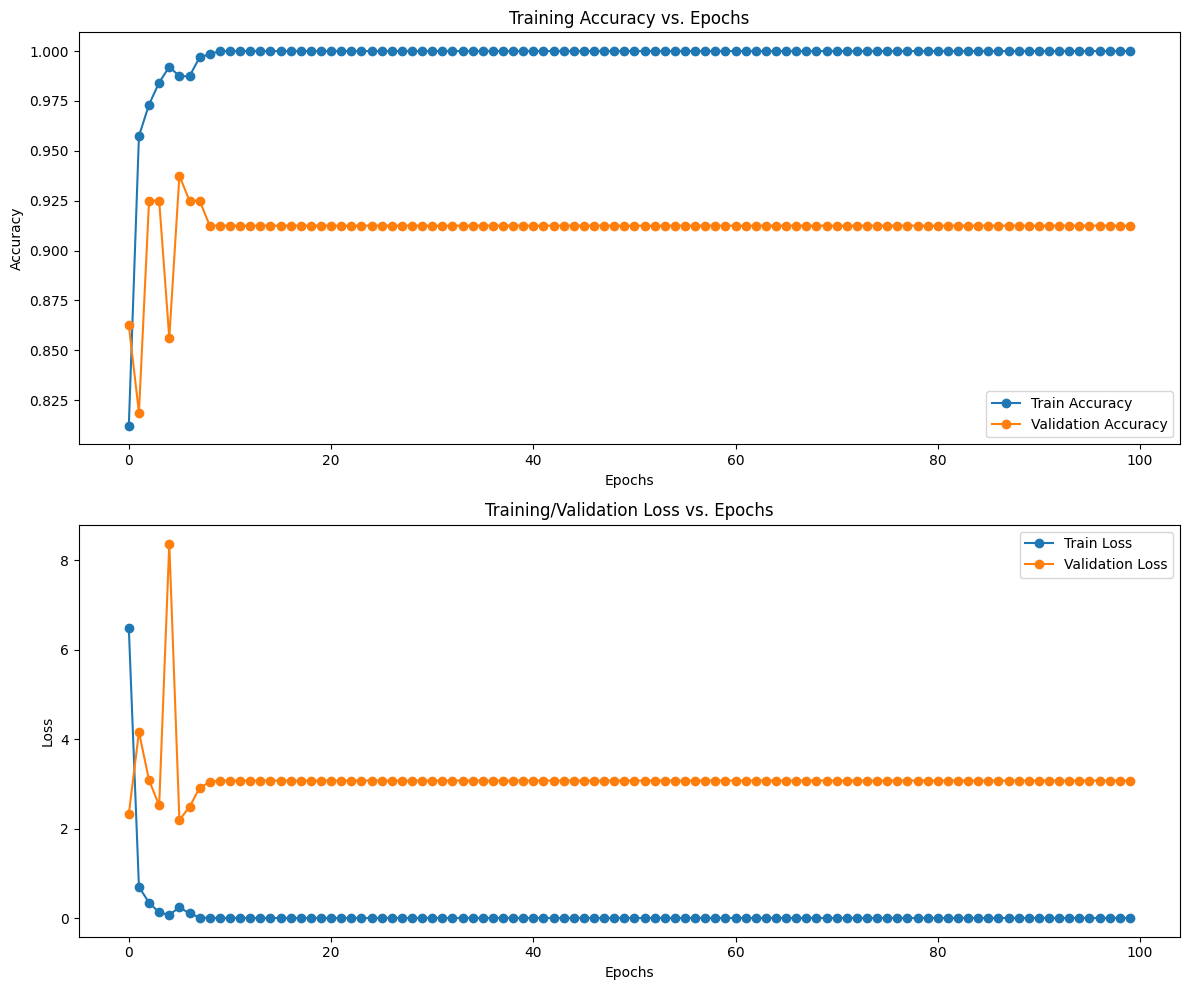

In [ ]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
# Convert softmax probabilities to predicted class (0 or 1)
predicted_classes = np.argmax(predictions, axis=1)
# Convert y_test from one-hot to single class
true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", cm)

# Precision, Recall, F1-Score
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# AUROC (Note: AUROC for multi-class requires probability scores)
# Ensure 'average' parameter is correctly set for multi-class (one-vs-rest approach)
auroc = roc_auc_score(y_test, predictions, multi_class='ovr')
print(f"AUROC: {auroc}")


Confusion Matrix:
 [[121   6]
 [  8  25]]
Precision: 0.8064516129032258
Recall: 0.7575757575757576
F1-Score: 0.7812499999999999
AUROC: 0.9379026485325699


DATA AUGUMENTATION

In [ ]:
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_test: ', X_test.shape)
print('y_test:', y_test.shape)

X_train:  (634, 200, 200, 3)
y_train:  (634, 2)
X_test:  (160, 200, 200, 3)
y_test: (160, 2)


In [ ]:
# Define the data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

# Create train and test generators
train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size=32)

validation_generator = test_datagen.flow(
    X_test,
    y_test,
    batch_size=32)


ALTERNATIVE MODEL: VGG

In [ ]:
import tqdm

train_generator.reset()
X_train_list, y_train_list = [], []

for _ in tqdm.tqdm(range(int(train_generator.n / BATCH_SIZE) - 1)):
    img, label = next(train_generator)
    X_train_list.append(img)
    y_train_list.append(label)

X_train = np.concatenate(X_train_list, axis=0)
y_train = np.concatenate(y_train_list, axis=0)

print(X_train.shape, y_train.shape)

100%|██████████| 18/18 [00:05<00:00,  3.08it/s]

(576, 200, 200, 3) (576, 2)


In [ ]:
import tqdm

validation_generator.reset()
X_test_list, y_test_list = [], []

for _ in tqdm.tqdm(range(int(validation_generator.n / BATCH_SIZE) - 1)):
    img, label = next(validation_generator)
    X_test_list.append(img)
    y_test_list.append(label)

X_test = np.concatenate(X_test_list, axis=0)
y_test = np.concatenate(y_test_list, axis=0)

print(X_test.shape, y_test.shape)

100%|██████████| 4/4 [00:00<00:00, 36.57it/s]

(128, 200, 200, 3) (128, 2)


In [ ]:
X_train.shape

(32, 200, 200, 3)

In [ ]:
# add preprocessing layer to the front of VGG
vgg = VGG16(input_shape=(X_train[0].shape), weights='imagenet', include_top=False)


In [ ]:
# don't train existing weights
for layer in vgg.layers:
  layer.trainable = False
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(2, activation='sigmoid')(x)





In [ ]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

In [ ]:
# view the structure of the model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:

# Assuming you have already defined and compiled your model
BATCH_SIZE =32
# Define the number of epochs
epochs = 100

# Train the model using the generator
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,  # Number of batches per epoch
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(X_test) // BATCH_SIZE,  # Number of validation batches per epoch
    verbose=1
)


Epoch 1/100
19/19 [==============================] - 21s 672ms/step - loss: 0.8668 - accuracy: 0.6993 - val_loss: 0.5499 - val_accuracy: 0.7188
Epoch 2/100
19/19 [==============================] - 7s 348ms/step - loss: 0.4111 - accuracy: 0.8156 - val_loss: 0.2907 - val_accuracy: 0.8500
Epoch 3/100
19/19 [==============================] - 8s 437ms/step - loss: 0.2743 - accuracy: 0.8721 - val_loss: 0.2208 - val_accuracy: 0.9125
Epoch 4/100
19/19 [==============================] - 8s 393ms/step - loss: 0.2716 - accuracy: 0.8920 - val_loss: 0.1965 - val_accuracy: 0.9250
Epoch 5/100
19/19 [==============================] - 7s 350ms/step - loss: 0.2487 - accuracy: 0.8987 - val_loss: 0.1863 - val_accuracy: 0.9125
Epoch 6/100
19/19 [==============================] - 8s 424ms/step - loss: 0.2116 - accuracy: 0.9103 - val_loss: 0.1813 - val_accuracy: 0.9187
Epoch 7/100
19/19 [==============================] - 10s 542ms/step - loss: 0.1899 - accuracy: 0.9219 - val_loss: 0.1694 - val_accuracy: 0.93

In [ ]:


# Save the model to Google Drive
#model.save("/content/drive/My Drive/my_Augumented_Egg_VGG_model.h5")
# Save the model to a file in the native Keras format
model.save("/content/drive/My Drive/my_Augumented_Egg_VGG_model.keras")



In [ ]:
from keras.models import load_model

# Load the saved model
loaded_model = load_model("/path/to/your/directory/my_model.keras")

# Now, you can use the loaded model for prediction
predictions = loaded_model.predict(test_data)

# Example: Printing the first prediction
print(predictions[0])


In [ ]:
from sklearn.metrics import average_precision_score
import numpy as np
predictions = model.predict(X_test)

threshold = 0.5
binary_predictions = np.where(predictions > threshold, 1, 0)

# Assuming y_test is already in a binary format (each element is either 0 or 1)
num_classes = predictions.shape[1]
average_precisions = []
for i in range(num_classes):
    # Calculate average precision for each class
    ap = average_precision_score(y_test[:, i], predictions[:, i])
    average_precisions.append(ap)
map_score = np.mean(average_precisions)
print(f"Mean Average Precision (MAP): {map_score}")

4/4 [==============================] - 1s 128ms/step
Mean Average Precision (MAP): 0.9889008564170667


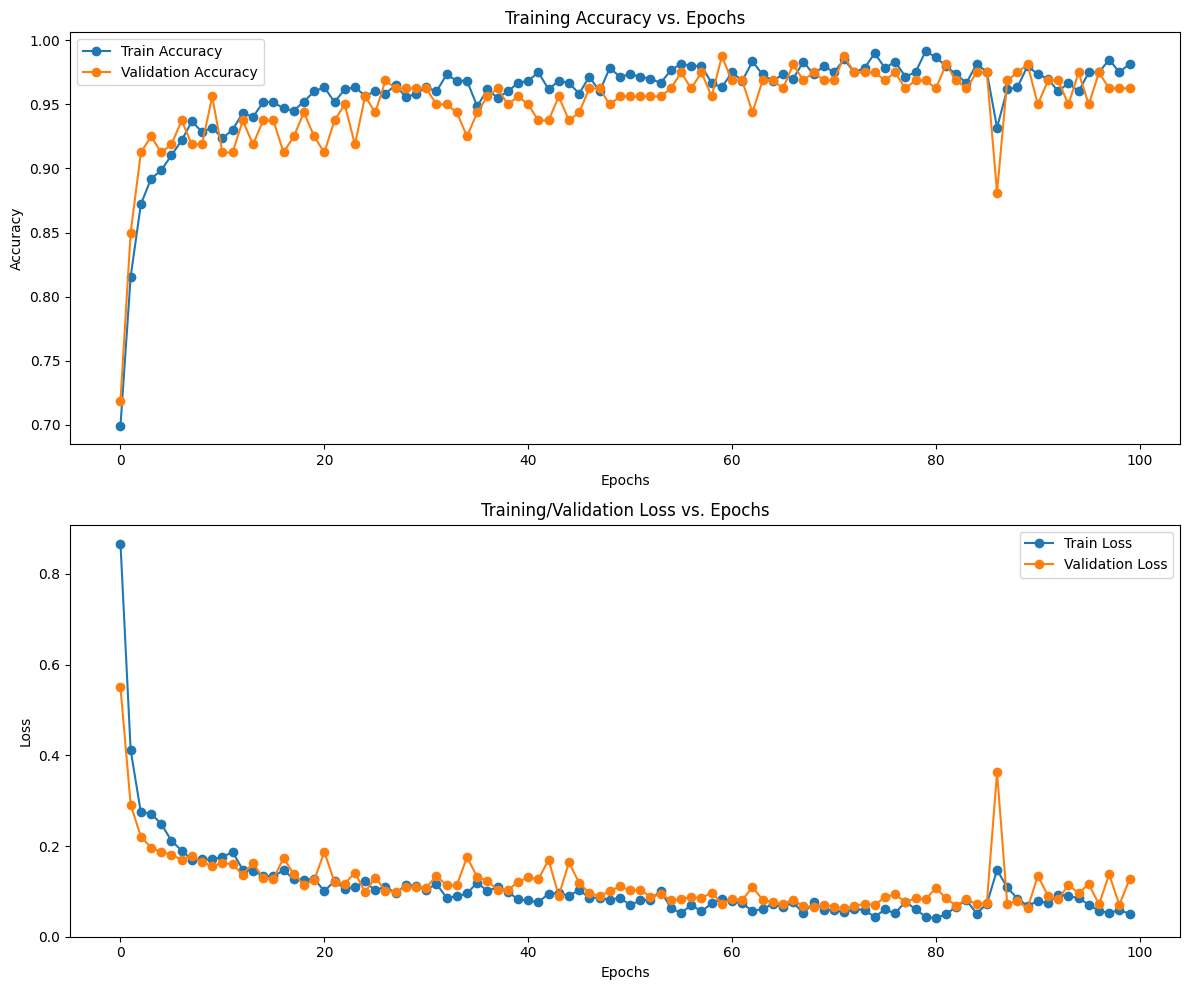

In [ ]:
# EVALUATE ACCURACY AND LOSS
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
# Convert softmax probabilities to predicted class (0 or 1)
predicted_classes = np.argmax(predictions, axis=1)
# Convert y_test from one-hot to single class
true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", cm)

# Precision, Recall, F1-Score
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# AUROC (Note: AUROC for multi-class requires probability scores)
# Ensure 'average' parameter is correctly set for multi-class (one-vs-rest approach)
auroc = roc_auc_score(y_test, predictions, multi_class='ovr')
print(f"AUROC: {auroc}")


Confusion Matrix:
 [[103   0]
 [  5  20]]
Precision: 1.0
Recall: 0.8
F1-Score: 0.888888888888889
AUROC: 0.9945631067961165


BASE MODEL: CNN

In [ ]:
from tensorflow.keras.models import Sequential
def create_model():
    model = Sequential([
        Conv2D(filters=16, kernel_size=(3, 3), padding='valid',input_shape=(X_train[0].shape)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=32, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=64, kernel_size=(3, 3), padding='valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Conv2D(filters=128, kernel_size=(3, 3), padding= 'valid', kernel_regularizer=l2(0.00005)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        BatchNormalization(),

        Flatten(),

        Dense(units=512, activation='relu'),
        Dropout(0.2),
        Dense(units=2, activation='softmax')
    ])

    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 16)      448       
                                                                 
 activation (Activation)     (None, 198, 198, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 16)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 99, 99, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 97, 97, 32)        0

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# Assuming you have already defined and compiled your model
BATCH_SIZE =32
# Define the number of epochs
epochs = 100

# Train the model using the generator
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // BATCH_SIZE,  # Number of batches per epoch
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=len(X_test) // BATCH_SIZE,  # Number of validation batches per epoch
    verbose=1
)


Epoch 1/100
18/18 [==============================] - 15s 287ms/step - loss: 0.9729 - accuracy: 0.7448 - val_loss: 0.8193 - val_accuracy: 0.2109
Epoch 2/100
18/18 [==============================] - 7s 414ms/step - loss: 0.7015 - accuracy: 0.8175 - val_loss: 0.5749 - val_accuracy: 0.7656
Epoch 3/100
18/18 [==============================] - 5s 286ms/step - loss: 0.6124 - accuracy: 0.8228 - val_loss: 0.5860 - val_accuracy: 0.7734
Epoch 4/100
18/18 [==============================] - 7s 386ms/step - loss: 0.4760 - accuracy: 0.8579 - val_loss: 0.5848 - val_accuracy: 0.8047
Epoch 5/100
18/18 [==============================] - 5s 279ms/step - loss: 0.4661 - accuracy: 0.8509 - val_loss: 1.5654 - val_accuracy: 0.1953
Epoch 6/100
18/18 [==============================] - 7s 388ms/step - loss: 0.3711 - accuracy: 0.8667 - val_loss: 0.8154 - val_accuracy: 0.4922
Epoch 7/100
18/18 [==============================] - 5s 283ms/step - loss: 0.3397 - accuracy: 0.8789 - val_loss: 0.7874 - val_accuracy: 0.492

In [ ]:
# Evaluate MAP
from sklearn.metrics import average_precision_score
import numpy as np
predictions = model.predict(X_test)

threshold = 0.5
binary_predictions = np.where(predictions > threshold, 1, 0)

# Assuming y_test is already in a binary format (each element is either 0 or 1)
num_classes = predictions.shape[1]
average_precisions = []
for i in range(num_classes):
    # Calculate average precision for each class
    ap = average_precision_score(y_test[:, i], predictions[:, i])
    average_precisions.append(ap)
map_score = np.mean(average_precisions)
print(f"Mean Average Precision (MAP): {map_score}")

4/4 [==============================] - 1s 27ms/step
Mean Average Precision (MAP): 0.9254284007877943


In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
# Convert softmax probabilities to predicted class (0 or 1)
predicted_classes = np.argmax(predictions, axis=1)
# Convert y_test from one-hot to single class
true_classes = np.argmax(y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", cm)

# Precision, Recall, F1-Score
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")

# AUROC (Note: AUROC for multi-class requires probability scores)
# Ensure 'average' parameter is correctly set for multi-class (one-vs-rest approach)
auroc = roc_auc_score(y_test, predictions, multi_class='ovr')
print(f"AUROC: {auroc}")


Confusion Matrix:
 [[98  5]
 [ 8 17]]
Precision: 0.7727272727272727
Recall: 0.68
F1-Score: 0.7234042553191491
AUROC: 0.96


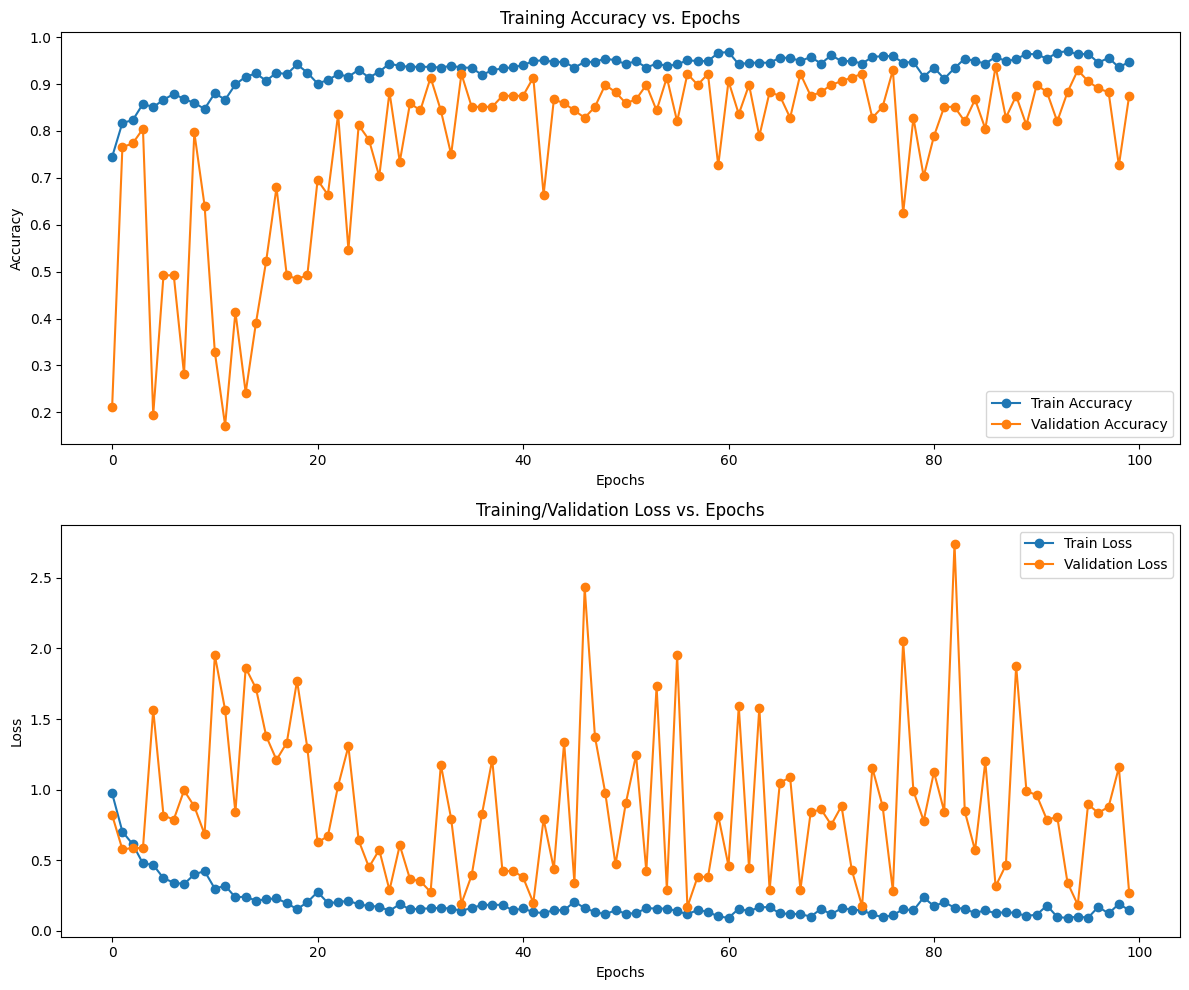

In [ ]:
# EVALUATE ACCURACY AND LOSS
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

plt.tight_layout()
plt.show()

In [ ]:


# Save the model to Google Drive
#model.save("/content/drive/My Drive/my_Augumented_Egg_VGG_model.h5")
# Save the model to a file in the native Keras format
model.save("/content/drive/My Drive/my_Augumented_Egg_CNN_model.keras")

